In [1]:
import sys
import xml.etree.ElementTree as ET


sys.path.append('../')
sys.path.append('../my_libs/')
sys.path.append('../my_libs/img/')

!{sys.executable} -m pip install --break-system-packages -r ../../pip-dependencies.txt

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import my_libs as ml
from my_libs.tools import *
from my_libs.fft import *
from my_libs.colors import *
from my_libs.img.processing import *
from ultralytics import YOLO


In [3]:
ml.tools.printf("Hello world!")

Hello world!

## Cvičení 13(14)

0)  Použijte knihovnu ultralytics. 
Knihovnu lze nainstalovat jako pip install ultralytics 
1)  Převeďte data do formátu podporovaného ultralyics dle 
https://docs.ultralytics.com/yolov5/tutorials/train_custom_data/  
Všechny anotace k obrázkům jsou v annotations.xml. Ke každému 
obrázku nazev.png v adresáři images je potřeba vytvořit odpovídající 
nazev.txt v adresáři labels. Každý objekt na obrázku je pak jeden 
řádek v txt souboru ve formátu 
class_idx x_center y_center width height 
kde  class_idx je index třídy a ostatní jsou souřadnice ohraničujícího 
obdélníka relativně vůči velikosti obrázku, viz 
https://docs.ultralytics.com/yolov5/tutorials/train_custom_data/#22-create-
labels  
2)  Důležitý je rovněž yaml soubor s cestami k datasetu a názvy tříd (v našem 
problému máme pouze jednu třídu „strawberry”), viz  
https://docs.ultralytics.com/yolov5/tutorials/train_custom_data/#21-create-
datasetyaml  
Data nemusíte rozdělovat na trénovací a validační, tzn. pro adresáře 
train i val použijte adresář obsahující všechny obrázky. 
3)  Stáhněte předtrénovaný YOLO model z 
https://docs.ultralytics.com/models/yolo11/#supported-tasks-and-modes 
dostatečně dobře bude fungovat i nejmenší model nano (n). 
4)  Natrénujte model a uložte, viz 
https://docs.ultralytics.com/modes/train/#usage-examples  
5)  Použijte model na obrázky v podadresáři test a vykreslete predikované 
obdélníky, viz 
https://docs.ultralytics.com/modes/predict/#key-features-of-predict-mode

Vykreslit results sám, ne pomocí zabudovaných funkcí

In [5]:
# Load a COCO-pretrained YOLO11n model
model = YOLO("yolo11n.pt")
#model2 = YOLO("yolo11n.pt")
#test_results = model2("datasets/strawberries/test/strawberry-bg-1300_800x.jpg")

""" for result in test_results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen """
#print(boxes)

' for result in test_results:\n    boxes = result.boxes  # Boxes object for bounding box outputs\n    masks = result.masks  # Masks object for segmentation masks outputs\n    keypoints = result.keypoints  # Keypoints object for pose outputs\n    probs = result.probs  # Probs object for classification outputs\n    obb = result.obb  # Oriented boxes object for OBB outputs\n    result.show()  # display to screen '

### Resize obrázky na 640x640px

In [6]:
input_folder = "strawberries/images"
output_folder = "strawberries/images_640px"

# NOT NEEDED IN THE END, DOES IT ITSELF
def resize_images(input_folder, output_folder):
    for file in os.listdir(input_folder):
        input_path = os.path.join(input_folder, file)
        output_path = os.path.join(output_folder, file)

        image = cv2.imread(input_path)
        image_640px = cv2.resize(image, (640, 640))

        cv2.imwrite(output_path, image_640px)
    print("Images resized and saved to: ", output_folder)

### Tvorba labels z annotations.xml

In [7]:
labels_folder = "datasets/strawberries/labels"
annot_folder = "datasets/strawberries/annotations.xml"

def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    for image in root.findall("image"):
            txt_filename = f"{labels_folder}/{image.attrib["id"]}.txt"
            txt_file = open(txt_filename, "w")
            image_width = int(image.attrib["width"])
            image_height = int(image.attrib["height"])
            for box in range(len(image)):
                # Relative 0-1 coords
                xtl = float(image[box].attrib["xtl"])/image_width # x top left
                ytl = float(image[box].attrib["ytl"])/image_height
                xbr = float(image[box].attrib["xbr"])/image_width # x bottom right
                ybr = float(image[box].attrib["ybr"])/image_height
                txt_file.write(f"0 {(xtl+xbr)/2} {(ytl+ybr)/2} {xbr-xtl} {ybr-ytl}\n") # class_id x_center y_center width height
            txt_file.close()

parse_annotation(annot_folder)

### Trénování modelu

In [6]:
results = model.train(data="dataset.yaml", epochs=100, lr0=0.001)

New https://pypi.org/project/ultralytics/8.3.51 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.50 🚀 Python-3.12.3 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fram

train: Scanning /home/vojta/PVI-Pocitacove_videni/cviceni/cv13/datasets/strawberries/labels.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
val: Scanning /home/vojta/PVI-Pocitacove_videni/cviceni/cv13/datasets/strawberries/labels.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.35G      1.968      3.379       1.76        129        640: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         40        475     0.0227      0.573     0.0361     0.0157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.44G      1.825      3.294      1.587        154        640: 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]

                   all         40        475     0.0267      0.676     0.0707     0.0312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.44G      1.516      3.138      1.342        176        640: 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]

                   all         40        475     0.0318      0.804      0.131     0.0633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.43G      1.534      2.844        1.3        149        640: 100%|██████████| 3/3 [00:00<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]

                   all         40        475     0.0352      0.888       0.36      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.59G      1.701      2.564      1.276        124        640: 100%|██████████| 3/3 [00:00<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]

                   all         40        475     0.0368      0.931      0.415      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.39G      1.578      2.283       1.25        113        640: 100%|██████████| 3/3 [00:00<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]

                   all         40        475     0.0366      0.924      0.436      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.44G       1.59      2.088      1.203        154        640: 100%|██████████| 3/3 [00:00<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]

                   all         40        475     0.0357      0.903      0.423      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.39G      1.512      1.787      1.209        124        640: 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]

                   all         40        475     0.0341      0.861      0.428      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.66G      1.562      1.758      1.221        137        640: 100%|██████████| 3/3 [00:00<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]

                   all         40        475     0.0526      0.695      0.377      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.41G      1.551      1.485      1.211        185        640: 100%|██████████| 3/3 [00:00<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]

                   all         40        475       0.74      0.221      0.402      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.51G      1.555      1.523      1.246        177        640: 100%|██████████| 3/3 [00:00<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]

                   all         40        475      0.645      0.234      0.321      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.45G      1.561      1.381      1.238        164        640: 100%|██████████| 3/3 [00:00<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]

                   all         40        475      0.627       0.24      0.344      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.44G      1.385      1.301      1.186         78        640: 100%|██████████| 3/3 [00:00<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]

                   all         40        475      0.648      0.244      0.307      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.39G      1.371      1.145      1.167        163        640: 100%|██████████| 3/3 [00:00<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]

                   all         40        475      0.658      0.269      0.322      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.66G        1.4      1.331      1.221         93        640: 100%|██████████| 3/3 [00:00<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.54it/s]

                   all         40        475      0.706      0.293      0.366       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100       4.4G      1.375      1.241      1.221        146        640: 100%|██████████| 3/3 [00:00<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]

                   all         40        475      0.761      0.301      0.384      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.47G      1.313      1.171      1.192         84        640: 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]

                   all         40        475       0.85      0.248       0.41      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.37G      1.499      1.239      1.251         95        640: 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]

                   all         40        475      0.889      0.227      0.435      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.41G      1.335      1.126      1.175        135        640: 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]

                   all         40        475      0.924      0.257       0.49      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.45G      1.405      1.147      1.176        193        640: 100%|██████████| 3/3 [00:00<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.52it/s]

                   all         40        475      0.541      0.242      0.331       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.55G       1.41      1.143       1.14        176        640: 100%|██████████| 3/3 [00:00<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]

                   all         40        475       0.72      0.255      0.405      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.45G      1.353      1.153      1.163         97        640: 100%|██████████| 3/3 [00:00<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]

                   all         40        475      0.889      0.371      0.599      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.38G      1.299      1.064      1.156        162        640: 100%|██████████| 3/3 [00:00<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]

                   all         40        475      0.863       0.49      0.682      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.46G      1.253      1.017      1.088        228        640: 100%|██████████| 3/3 [00:00<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.31it/s]

                   all         40        475      0.781      0.558      0.691      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.47G      1.278      1.056      1.125        165        640: 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.27it/s]

                   all         40        475      0.723      0.518      0.605      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.44G      1.357      1.103      1.224        144        640: 100%|██████████| 3/3 [00:00<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.25it/s]

                   all         40        475      0.744      0.594      0.678      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.45G      1.308      1.061      1.136        167        640: 100%|██████████| 3/3 [00:00<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.02it/s]

                   all         40        475      0.829      0.716      0.801      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.45G      1.265      1.032      1.135        108        640: 100%|██████████| 3/3 [00:00<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.20it/s]

                   all         40        475      0.779      0.745      0.813      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.45G      1.253     0.9909      1.139        190        640: 100%|██████████| 3/3 [00:00<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.19it/s]

                   all         40        475      0.779      0.745      0.813      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.39G      1.287      1.027      1.154        200        640: 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.26it/s]

                   all         40        475      0.787      0.729      0.799      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.49G      1.283      1.062      1.156        153        640: 100%|██████████| 3/3 [00:00<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.18it/s]

                   all         40        475      0.819      0.779       0.84      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.42G      1.181      1.052      1.119        108        640: 100%|██████████| 3/3 [00:00<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.20it/s]

                   all         40        475      0.822      0.777      0.859      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.55G      1.221      1.012      1.109        146        640: 100%|██████████| 3/3 [00:00<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]

                   all         40        475      0.822      0.777      0.859      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.48G      1.193     0.9718      1.089        224        640: 100%|██████████| 3/3 [00:00<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.43it/s]

                   all         40        475      0.859        0.8      0.894      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.41G      1.121      0.923      1.078        131        640: 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.37it/s]

                   all         40        475      0.854      0.762      0.856      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.44G       1.22     0.9856      1.096        205        640: 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.52it/s]

                   all         40        475      0.751      0.678      0.746      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.41G      1.281     0.9548      1.116        193        640: 100%|██████████| 3/3 [00:00<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.58it/s]

                   all         40        475      0.751      0.678      0.746      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.46G      1.152     0.9199      1.078        236        640: 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.53it/s]

                   all         40        475      0.808      0.737      0.826      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       4.4G      1.113     0.8776      1.075        150        640: 100%|██████████| 3/3 [00:00<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.53it/s]

                   all         40        475       0.84      0.787      0.874       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.45G      1.214     0.9074      1.096        200        640: 100%|██████████| 3/3 [00:00<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]

                   all         40        475      0.855      0.783      0.858      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.38G      1.278     0.9452      1.115        217        640: 100%|██████████| 3/3 [00:00<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]

                   all         40        475      0.855      0.783      0.858      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.45G      1.199      0.906      1.059        119        640: 100%|██████████| 3/3 [00:00<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]

                   all         40        475      0.799      0.709      0.782      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.47G      1.186     0.8888      1.068        160        640: 100%|██████████| 3/3 [00:00<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]

                   all         40        475      0.842      0.728      0.818      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.36G      1.221     0.9209      1.077        162        640: 100%|██████████| 3/3 [00:00<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]

                   all         40        475      0.889      0.819      0.908      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.47G      1.163     0.8891      1.078        150        640: 100%|██████████| 3/3 [00:00<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]

                   all         40        475      0.889      0.819      0.908      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.41G      1.125     0.9223      1.081        180        640: 100%|██████████| 3/3 [00:00<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.56it/s]

                   all         40        475      0.911      0.822      0.922      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.45G       1.15     0.8604      1.077        201        640: 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]

                   all         40        475      0.881      0.829      0.905      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.49G       1.08     0.8415      1.052        114        640: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]

                   all         40        475      0.913      0.811      0.918      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.43G       1.04     0.8597      1.074        123        640: 100%|██████████| 3/3 [00:00<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]

                   all         40        475      0.913      0.811      0.918      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.44G      1.165     0.9054      1.054        258        640: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.33it/s]

                   all         40        475      0.888      0.848      0.931      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.45G      1.069     0.8539       1.07        103        640: 100%|██████████| 3/3 [00:00<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.58it/s]

                   all         40        475      0.909      0.845      0.948      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.57G       1.08       0.88      1.055         91        640: 100%|██████████| 3/3 [00:00<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]

                   all         40        475      0.932       0.84       0.95      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.47G      1.013     0.8321      1.019        212        640: 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]

                   all         40        475      0.932       0.84       0.95      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.41G      1.027     0.7933      1.017        217        640: 100%|██████████| 3/3 [00:00<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.39it/s]

                   all         40        475      0.893      0.855      0.946       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.42G     0.9974     0.7909      1.019        181        640: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.27it/s]

                   all         40        475      0.883      0.886      0.944      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       4.3G      1.031     0.8677      1.054         93        640: 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.45it/s]

                   all         40        475      0.894      0.888      0.947      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.39G     0.9423     0.7595     0.9956        184        640: 100%|██████████| 3/3 [00:00<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.25it/s]

                   all         40        475      0.894      0.888      0.947      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.44G     0.9992     0.7744      1.017        171        640: 100%|██████████| 3/3 [00:00<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.47it/s]

                   all         40        475      0.903      0.881      0.946      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.42G      1.011     0.7872      1.025        178        640: 100%|██████████| 3/3 [00:00<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.95it/s]

                   all         40        475      0.918      0.848      0.936      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.43G     0.9551      0.755      1.014        131        640: 100%|██████████| 3/3 [00:00<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.22it/s]

                   all         40        475      0.929       0.85      0.943      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.42G      1.009     0.7974      1.017        132        640: 100%|██████████| 3/3 [00:00<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.15it/s]

                   all         40        475      0.929       0.85      0.943      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.43G     0.9635     0.7693      1.044        127        640: 100%|██████████| 3/3 [00:00<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.26it/s]

                   all         40        475      0.912      0.888      0.954      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.42G     0.9382     0.7321     0.9858        185        640: 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.34it/s]

                   all         40        475      0.938      0.886      0.963      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.37G     0.9511     0.7177     0.9855        202        640: 100%|██████████| 3/3 [00:00<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.75it/s]

                   all         40        475      0.946      0.895      0.963      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.47G     0.9209     0.7414      1.016        129        640: 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.48it/s]

                   all         40        475      0.946      0.895      0.963      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.45G      0.949     0.7455     0.9954        188        640: 100%|██████████| 3/3 [00:00<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.05it/s]

                   all         40        475      0.947      0.901      0.965      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.46G     0.9865     0.7703     0.9974        285        640: 100%|██████████| 3/3 [00:00<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.46it/s]

                   all         40        475      0.943      0.905      0.965      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.41G     0.8915      0.714     0.9772        165        640: 100%|██████████| 3/3 [00:00<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.50it/s]

                   all         40        475      0.942      0.914      0.972      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.46G     0.9372     0.7274     0.9786        141        640: 100%|██████████| 3/3 [00:00<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.48it/s]

                   all         40        475      0.942      0.914      0.972      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100       4.4G     0.8985     0.7614      1.017         94        640: 100%|██████████| 3/3 [00:00<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.31it/s]

                   all         40        475      0.936      0.925      0.976       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.45G     0.8735     0.6929     0.9765        100        640: 100%|██████████| 3/3 [00:00<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.52it/s]

                   all         40        475      0.931      0.926       0.97      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.47G     0.9386      0.706     0.9714        182        640: 100%|██████████| 3/3 [00:00<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.29it/s]

                   all         40        475      0.949      0.907       0.97      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.47G      1.008     0.7442      0.994        147        640: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.46it/s]

                   all         40        475      0.949      0.907       0.97      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.45G     0.9337     0.7327     0.9839        165        640: 100%|██████████| 3/3 [00:00<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.47it/s]

                   all         40        475      0.949      0.904      0.978       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.49G     0.8912     0.6923     0.9744        129        640: 100%|██████████| 3/3 [00:00<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.17it/s]

                   all         40        475      0.944       0.92      0.979      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.41G     0.8654     0.6794      0.963        122        640: 100%|██████████| 3/3 [00:00<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.26it/s]

                   all         40        475      0.962      0.911       0.98      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.39G     0.8741     0.7142     0.9816        185        640: 100%|██████████| 3/3 [00:00<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.39it/s]

                   all         40        475      0.962      0.911       0.98      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.41G     0.8987     0.6898      0.965        143        640: 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.39it/s]

                   all         40        475      0.941       0.94      0.975      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.43G     0.9369     0.7313     0.9968        107        640: 100%|██████████| 3/3 [00:00<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.45it/s]

                   all         40        475      0.965      0.922      0.973       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.45G     0.8503     0.6829      0.965        136        640: 100%|██████████| 3/3 [00:00<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.23it/s]

                   all         40        475      0.961      0.929      0.976      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.44G      0.854     0.6637     0.9597        202        640: 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.50it/s]

                   all         40        475      0.961      0.929      0.976      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.39G     0.8862     0.6869     0.9636        175        640: 100%|██████████| 3/3 [00:00<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.26it/s]

                   all         40        475      0.978      0.922      0.983      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.38G     0.8678     0.6863     0.9566        152        640: 100%|██████████| 3/3 [00:00<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.10it/s]

                   all         40        475      0.976      0.928      0.984      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.36G     0.8478     0.6829     0.9596        177        640: 100%|██████████| 3/3 [00:00<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.31it/s]

                   all         40        475      0.974      0.924      0.981      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100       4.4G      0.815     0.6431     0.9508        199        640: 100%|██████████| 3/3 [00:00<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.25it/s]

                   all         40        475      0.974      0.924      0.981      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.46G     0.8105     0.6615     0.9395         88        640: 100%|██████████| 3/3 [00:00<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.24it/s]

                   all         40        475      0.974      0.922       0.98      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.46G     0.8215     0.6587     0.9513        147        640: 100%|██████████| 3/3 [00:00<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.20it/s]

                   all         40        475      0.978      0.924       0.98      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.43G     0.8411     0.6561     0.9314        105        640: 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.44it/s]

                   all         40        475      0.969      0.937       0.98      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.39G     0.7686     0.6298     0.9456        139        640: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.00it/s]

                   all         40        475      0.969      0.937       0.98      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      4.41G     0.8347     0.6483     0.9558        147        640: 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.26it/s]

                   all         40        475      0.969      0.941       0.98      0.812


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.43G     0.8068     0.7378      0.947        110        640: 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.98it/s]

                   all         40        475      0.972      0.937      0.979      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.29G     0.8023     0.6862     0.9362        135        640: 100%|██████████| 3/3 [00:00<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.19it/s]

                   all         40        475       0.97      0.935      0.979        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.43G     0.7348     0.6634     0.9418         68        640: 100%|██████████| 3/3 [00:00<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.43it/s]

                   all         40        475       0.97      0.935      0.979        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      4.38G     0.7228     0.6464     0.9325         82        640: 100%|██████████| 3/3 [00:00<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.31it/s]

                   all         40        475      0.958      0.935      0.977      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.43G     0.7618     0.6531     0.9195         68        640: 100%|██████████| 3/3 [00:00<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.10it/s]

                   all         40        475      0.948      0.935      0.976      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      4.44G     0.7402     0.6428      0.922         79        640: 100%|██████████| 3/3 [00:00<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.27it/s]

                   all         40        475      0.948      0.939      0.976      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.39G     0.8327     0.6998     0.9537        126        640: 100%|██████████| 3/3 [00:00<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.31it/s]

                   all         40        475      0.948      0.939      0.976      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.38G       0.71     0.6442     0.9095         64        640: 100%|██████████| 3/3 [00:00<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.25it/s]

                   all         40        475      0.954      0.945      0.979      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100       4.4G     0.7407     0.6333      0.916         89        640: 100%|██████████| 3/3 [00:00<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.91it/s]

                   all         40        475       0.96      0.941      0.982      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.39G     0.7314     0.6333     0.9214        110        640: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.24it/s]

                   all         40        475      0.951      0.947      0.985       0.82



100 epochs completed in 0.042 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.50 🚀 Python-3.12.3 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.79it/s]


                   all         40        475      0.951      0.947      0.985      0.819
Speed: 0.4ms preprocess, 3.5ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/train


### Nasazení modelu na test data

In [52]:
trained_model_path = "runs/detect/train_lr0_0001/weights/best.pt"
trained_model = YOLO(trained_model_path)

test_images = []
test_images_path = "datasets/strawberries/test"
for img in os.listdir(test_images_path):
    test_images.append(os.path.join(test_images_path, img))

test_results = trained_model.predict(test_images)

/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


0: 640x640 13 strawberrys, 31.7ms
1: 640x640 5 strawberrys, 31.7ms
2: 640x640 11 strawberrys, 31.7ms
3: 640x640 6 strawberrys, 31.7ms
4: 640x640 7 strawberrys, 31.7ms
Speed: 3.8ms preprocess, 31.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


### Zpracování výsledků

(269, 250)
(229, 210)
(224, 272)
(397, 261)
(173, 75)
(120, 227)
(0, 196)
(199, 284)
(380, 190)
(213, 228)
(322, 305)
(414, 333)
(0, 437)
(228, 266)
(558, 178)
(663, 180)
(533, 180)
(388, 287)
(19, 593)
(41, 449)
(101, 321)
(216, 524)
(674, 186)
(308, 477)
(95, 19)
(360, 19)
(166, 131)
(538, 267)
(562, 129)
(523, 491)
(639, 473)
(435, 552)
(476, 400)
(817, 385)
(886, 286)
(92, 55)
(678, 301)
(0, 109)
(261, 42)
(171, 27)
(354, 48)
(545, 185)


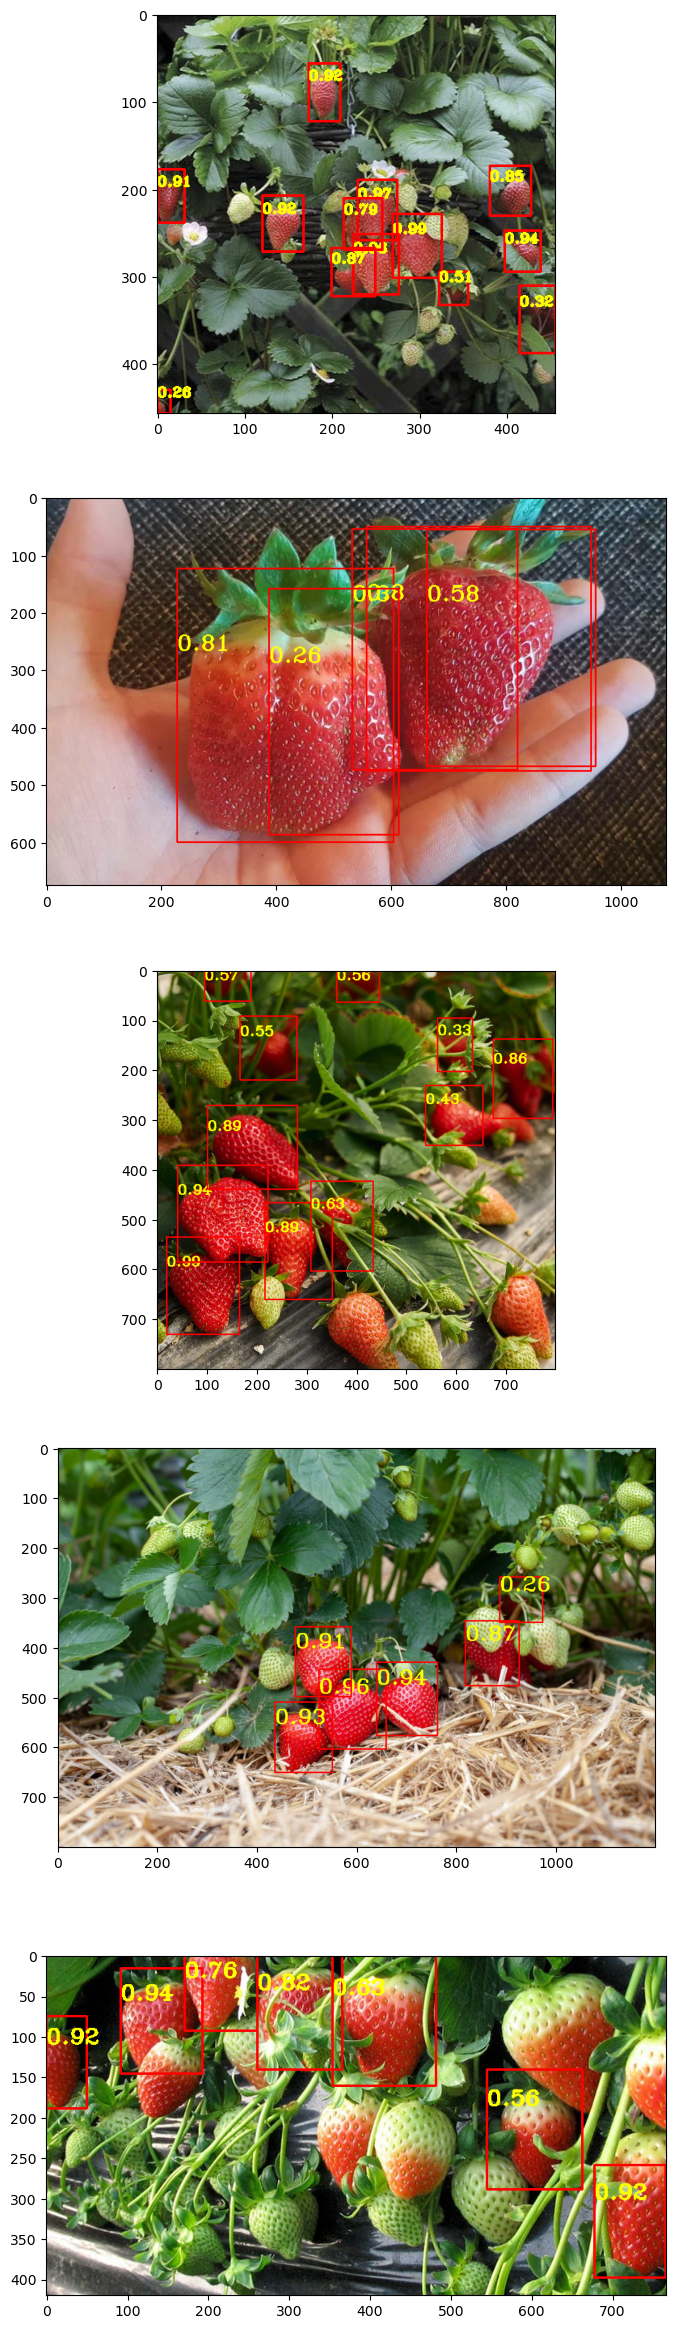

In [ ]:
imgs_with_boxes = []
for result in test_results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    confidence = boxes.conf.tolist()
    #result.show()  # display to screen

    # DRAW BOXES
    orig_img = cv2.cvtColor(result.orig_img, cv2.COLOR_BGR2RGB)
    boxes_xyxy = boxes.xyxy.tolist()
    for i in range(len(boxes_xyxy)):
        tl = (int(boxes_xyxy[i][0]), int(boxes_xyxy[i][1]))
        br = (int(boxes_xyxy[i][2]), int(boxes_xyxy[i][3]))
        tl_for_text = (int(boxes_xyxy[i][0]), int(boxes_xyxy[i][1] + 0.3*(int(boxes_xyxy[i][3]) - int(boxes_xyxy[i][1])))) # Posunout o 30 % níž
        orig_img = cv2.rectangle(orig_img, tl, br, (255, 0, 0), 2)
        orig_img = cv2.putText(orig_img, str(round(confidence[i],  2)), tl_for_text, 5, result.orig_shape[1]/550, (255, 255, 0), 2)
    imgs_with_boxes.append(orig_img)

# SHOW IMAGES WITH BOXES
plt.figure(figsize=(8, 30))  
for i in range(len(imgs_with_boxes)):
    plt.subplot(5, 1, i+1)
    plt.imshow(imgs_with_boxes[i])
plt.show()

In [7]:
print(model.val())

Ultralytics 8.3.50 🚀 Python-3.12.3 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)


val: Scanning /home/vojta/PVI-Pocitacove_videni/cviceni/cv13/datasets/strawberries/labels.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]


                   all         40        475      0.957      0.945      0.983      0.819
Speed: 3.0ms preprocess, 21.5ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f4336cc87d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.03303